<a href="https://colab.research.google.com/github/levi3001/cs470_term_project_toxic_classification/blob/main/toxic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import os
import random
import re

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import re
from tqdm.auto import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip  drive/MyDrive/jigsaw-toxic-comment-classification-challenge.zip -d data

Archive:  drive/MyDrive/jigsaw-toxic-comment-classification-challenge.zip
  inflating: data/sample_submission.csv.zip  
  inflating: data/test.csv.zip       
  inflating: data/test_labels.csv.zip  
  inflating: data/train.csv.zip      


In [4]:
train_data=pd.read_csv('data/train.csv.zip')
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
test_data=pd.read_csv('data/test.csv.zip')
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [6]:
test_label=pd.read_csv('data/test_labels.csv.zip')
test_label

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
#https://www.kaggle.com/gtskyler/toxic-comments-bert

In [8]:
train_data['comment_texxt']=train_data['comment_text'].map(lambda text: clean_text(text))
test_data['comment_texxt']=test_data['comment_text'].map(lambda text: clean_text(text))

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import re

vocab_size = 6000
tokenizer = Tokenizer(num_words=vocab_size, split=' ', oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['comment_text'].values)


In [10]:
train_val_x = train_data['comment_text'].values
train_val_y = train_data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values
train_x, val_x, train_y, val_y = train_test_split(train_val_x,train_val_y, test_size=0.2, random_state=30)

In [11]:
print(len(train_x))
print(train_y.shape)

127656
(127656, 6)


In [12]:
tokenizer = Tokenizer(num_words = 100000, oov_token='<oov>')
tokenizer.fit_on_texts(train_data['comment_text'])

In [13]:
train_seq = tokenizer.texts_to_sequences(train_x)
maxlen = max([len(x) for x in train_seq])
train_pad = pad_sequences(train_seq, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')
print(maxlen)

1403


In [14]:
val_seq = tokenizer.texts_to_sequences(val_x)
val_pad = pad_sequences(val_seq, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')

In [15]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

210339

In [16]:
!wget dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2021-11-20 17:24:27--  http://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  52.8MB/s    in 27s     

2021-11-20 17:24:54 (54.6 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [17]:
!unzip crawl-300d-2M.vec.zip 

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [18]:
import io
print('loading word embeddings...')
embeddings_index = {}
f = io.open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


0it [00:00, ?it/s]

found 1999996 word vectors


In [22]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = vocab_size
embedding_matrix = np.zeros((nb_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 108220


In [24]:
model = tf.keras.Sequential(
    [tf.keras.layers.Embedding(input_dim = vocab_size,output_dim = 300,input_length = maxlen,weights=[embedding_matrix]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6)
    ])

In [25]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])
model.fit(train_pad,train_y, epochs = 2, validation_data=(val_pad, val_y), batch_size = 32)

Epoch 1/2
3990/3990 [==============================] - 650s 161ms/step - loss: 0.0546 - accuracy: 0.9789 - val_loss: 0.0447 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 644s 161ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.0424 - val_accuracy: 0.9923


In [26]:
test_seq = tokenizer.texts_to_sequences(test_data.comment_text)
test_pad = pad_sequences(test_seq, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')
predicted = tf.math.sigmoid(model.predict(test_pad, batch_size = 200))
predict = np.hstack((test_data.id[:, np.newaxis], predicted))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [27]:
subm = pd.DataFrame(predict, columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
subm.to_csv('subm.csv', index = False)

In [28]:
subm

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.988414,0.189765,0.955813,0.029313,0.847096,0.354981
1,0000247867823ef7,0.000178022,4.17261e-07,1.46116e-05,2.40856e-06,7.23422e-06,2.39614e-06
2,00013b17ad220c46,0.000578599,3.38327e-06,0.000114595,8.44434e-06,2.99208e-05,9.12727e-06
3,00017563c3f7919a,0.000522951,6.48672e-06,3.54218e-05,4.31723e-05,5.97763e-05,1.88689e-05
4,00017695ad8997eb,0.00100809,1.27787e-05,0.000109722,3.85049e-05,7.19184e-05,3.16169e-05
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.566831,0.0011156,0.122031,0.000778948,0.0264501,0.0013428
153160,fffd7a9a6eb32c16,0.00271604,1.64712e-05,0.000191134,5.38324e-05,0.000260561,0.000131835
153161,fffda9e8d6fafa9e,0.000780383,8.97054e-06,0.000173499,1.71007e-05,6.49465e-05,1.64345e-05
153162,fffe8f1340a79fc2,0.00114952,2.1168e-06,7.53439e-05,9.61183e-06,4.24199e-05,2.51856e-05


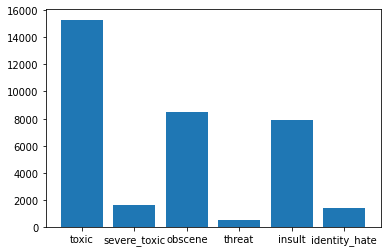

In [29]:
import matplotlib.pyplot as plt
name=  [ 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
values= [sum(train_data[name[i]]>0) for i in range(len(name))]
plt.bar(name, values)
plt.show()